<img src="imagenes/ia.png", width="200" \>
# Comparación de diferentes clasificadores

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/).

En esta libreta se muestra para 3 conjuntos de datos artificiales bidimensionales, la forma en que se realiza la clasificación con distintos métodos. Principalmente lo hacemos para poder sacar conclusiones sobre en que situaciones un método puede ser mejor que otros, y que está haciendo internamente.

Código obtenido de la documentación de scikit-learn, el cual se puede consultar [aquí](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [1]:
# El de base
import numpy as np

# Las gráficas
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Para separar los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split

# Para normalizar los datos (desviación estandar)
from sklearn.preprocessing import StandardScaler

# Los conjuntos de datos artificiales típicos para probar clasificadores
from sklearn.datasets import make_moons, make_circles, make_classification

# Los métodos de aprendizaje a utilizar
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline


## 1. Generando los 3 conjuntos de datos

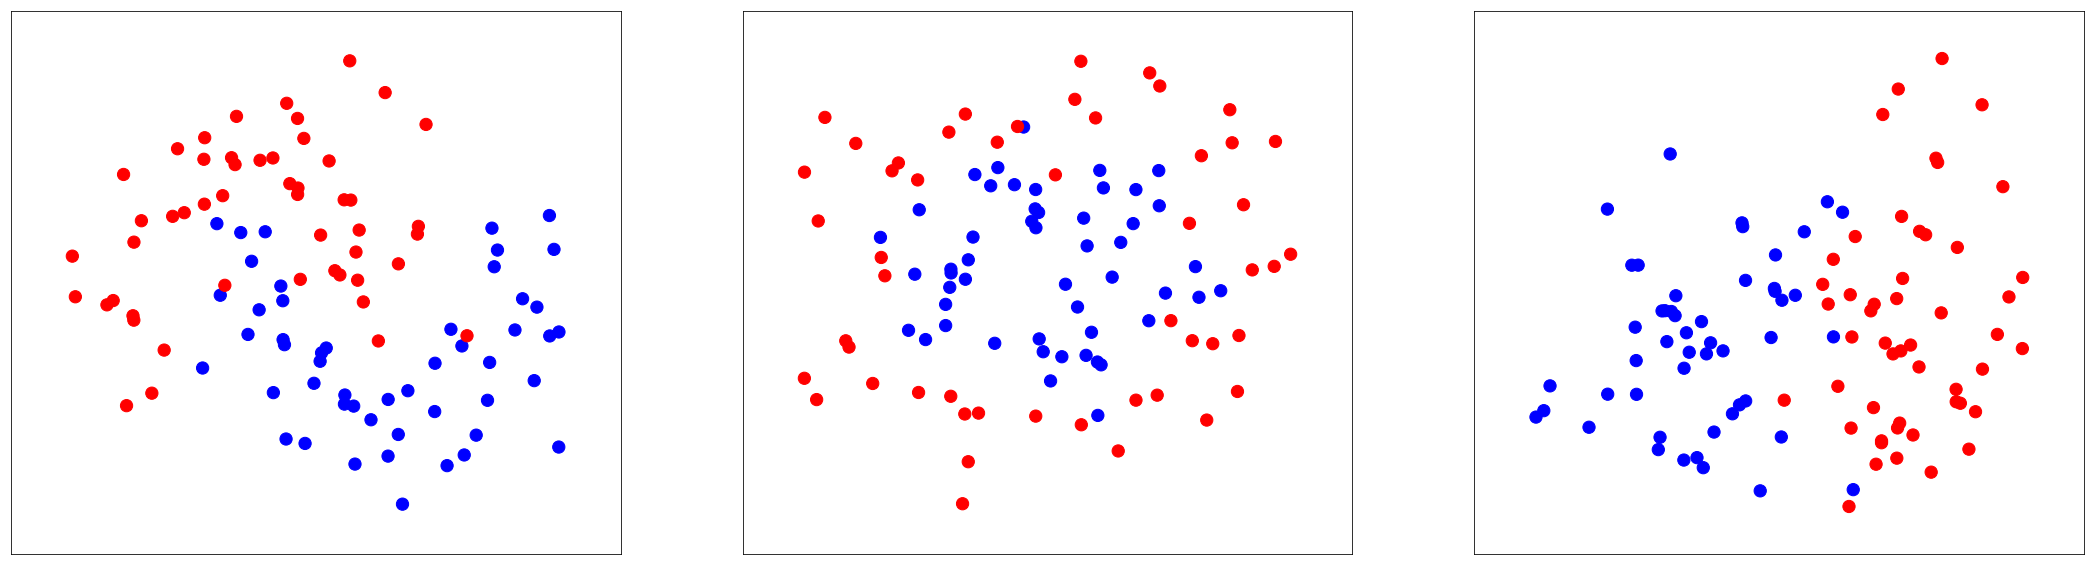

In [2]:

# Del módulo para generar conjuntos de datos artificiales, para hacer conjuntos de lunas y circulos:
lunas = make_moons(noise=0.3, random_state=0)
circulos = make_circles(noise=0.2, factor=0.5, random_state=1)

# Ahora generamos un conjunto de datos linealmente separables
X, y = make_classification(n_features=2,             #  Dos dimensiones para poderlos graficar 
                           n_redundant=0,            #  Sin dimensiones redundantes, no nos interesa probar esto ahora
                           n_informative=2,          #  Las dos dimensiones informativas (no correlacionadas)
                           random_state=1,           #  Semilla, siempre la misma para que todos tengan los mismos resultados
                           n_clusters_per_class=1)   #  Una sola forma por clase para hacerlo más sencillo

# Le agregamos ruido a la separación lineal (algunos puntos mal clasificados)
rng = np.random.RandomState(2)           #  Un generador de números pseudoaleatorios con la semilla impuesta
X += 2 * rng.uniform(size=X.shape)       #  A cada punto se le suma un error con una distribución uniforme en ambas dimensiones
lineal = (X, y)

datasets = [lunas, circulos, lineal]    # Una lista de tuplas (X, y)

# Y los graficamos para verlos
figure = plt.figure(figsize=(30, 10))
cm_escala = ListedColormap(['#FF0000', '#0000FF'])

for (i, ds) in enumerate(datasets):
    # Selecciona los valores del conjunto de datos y los escala
    X, y = ds
    X = StandardScaler().fit_transform(X)

    # Grafica
    ax = plt.subplot(1, 3, i+1)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=150, cmap=cm_escala)
    ax.set_xlim(X[:, 0].min() - .5, X[:, 0].max() + .5)
    ax.set_ylim(X[:, 1].min() - .5, X[:, 1].max() + .5)
    ax.set_xticks(())
    ax.set_yticks(())
    
figure.subplots_adjust(left=.02, right=.98)    
plt.show()


## 2. Define la bateria de clasificadores

In [3]:
titulos = [u"Vecinos próximos", "SVM lineal", "SVM gaussiano", u"Árbol de desición",
           u"Bosques aleatorios", "AdaBoost", "Naive Bayes", "Discriminante lineal",
           "Discriminante cuadrátco"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


## 3. Generando la clasificación con cada método diferente

Vamos a generar por cada conjunto de datos de entrenamiento y prueba, y aparte vamos a clasificar todos los datos dentro del meshgrid, para asignarles colores en el fondo, que nos permitan visualizar el tipo de particiones del plano que se genera con cada uno de los métodos de clasificación

Base de datos 0


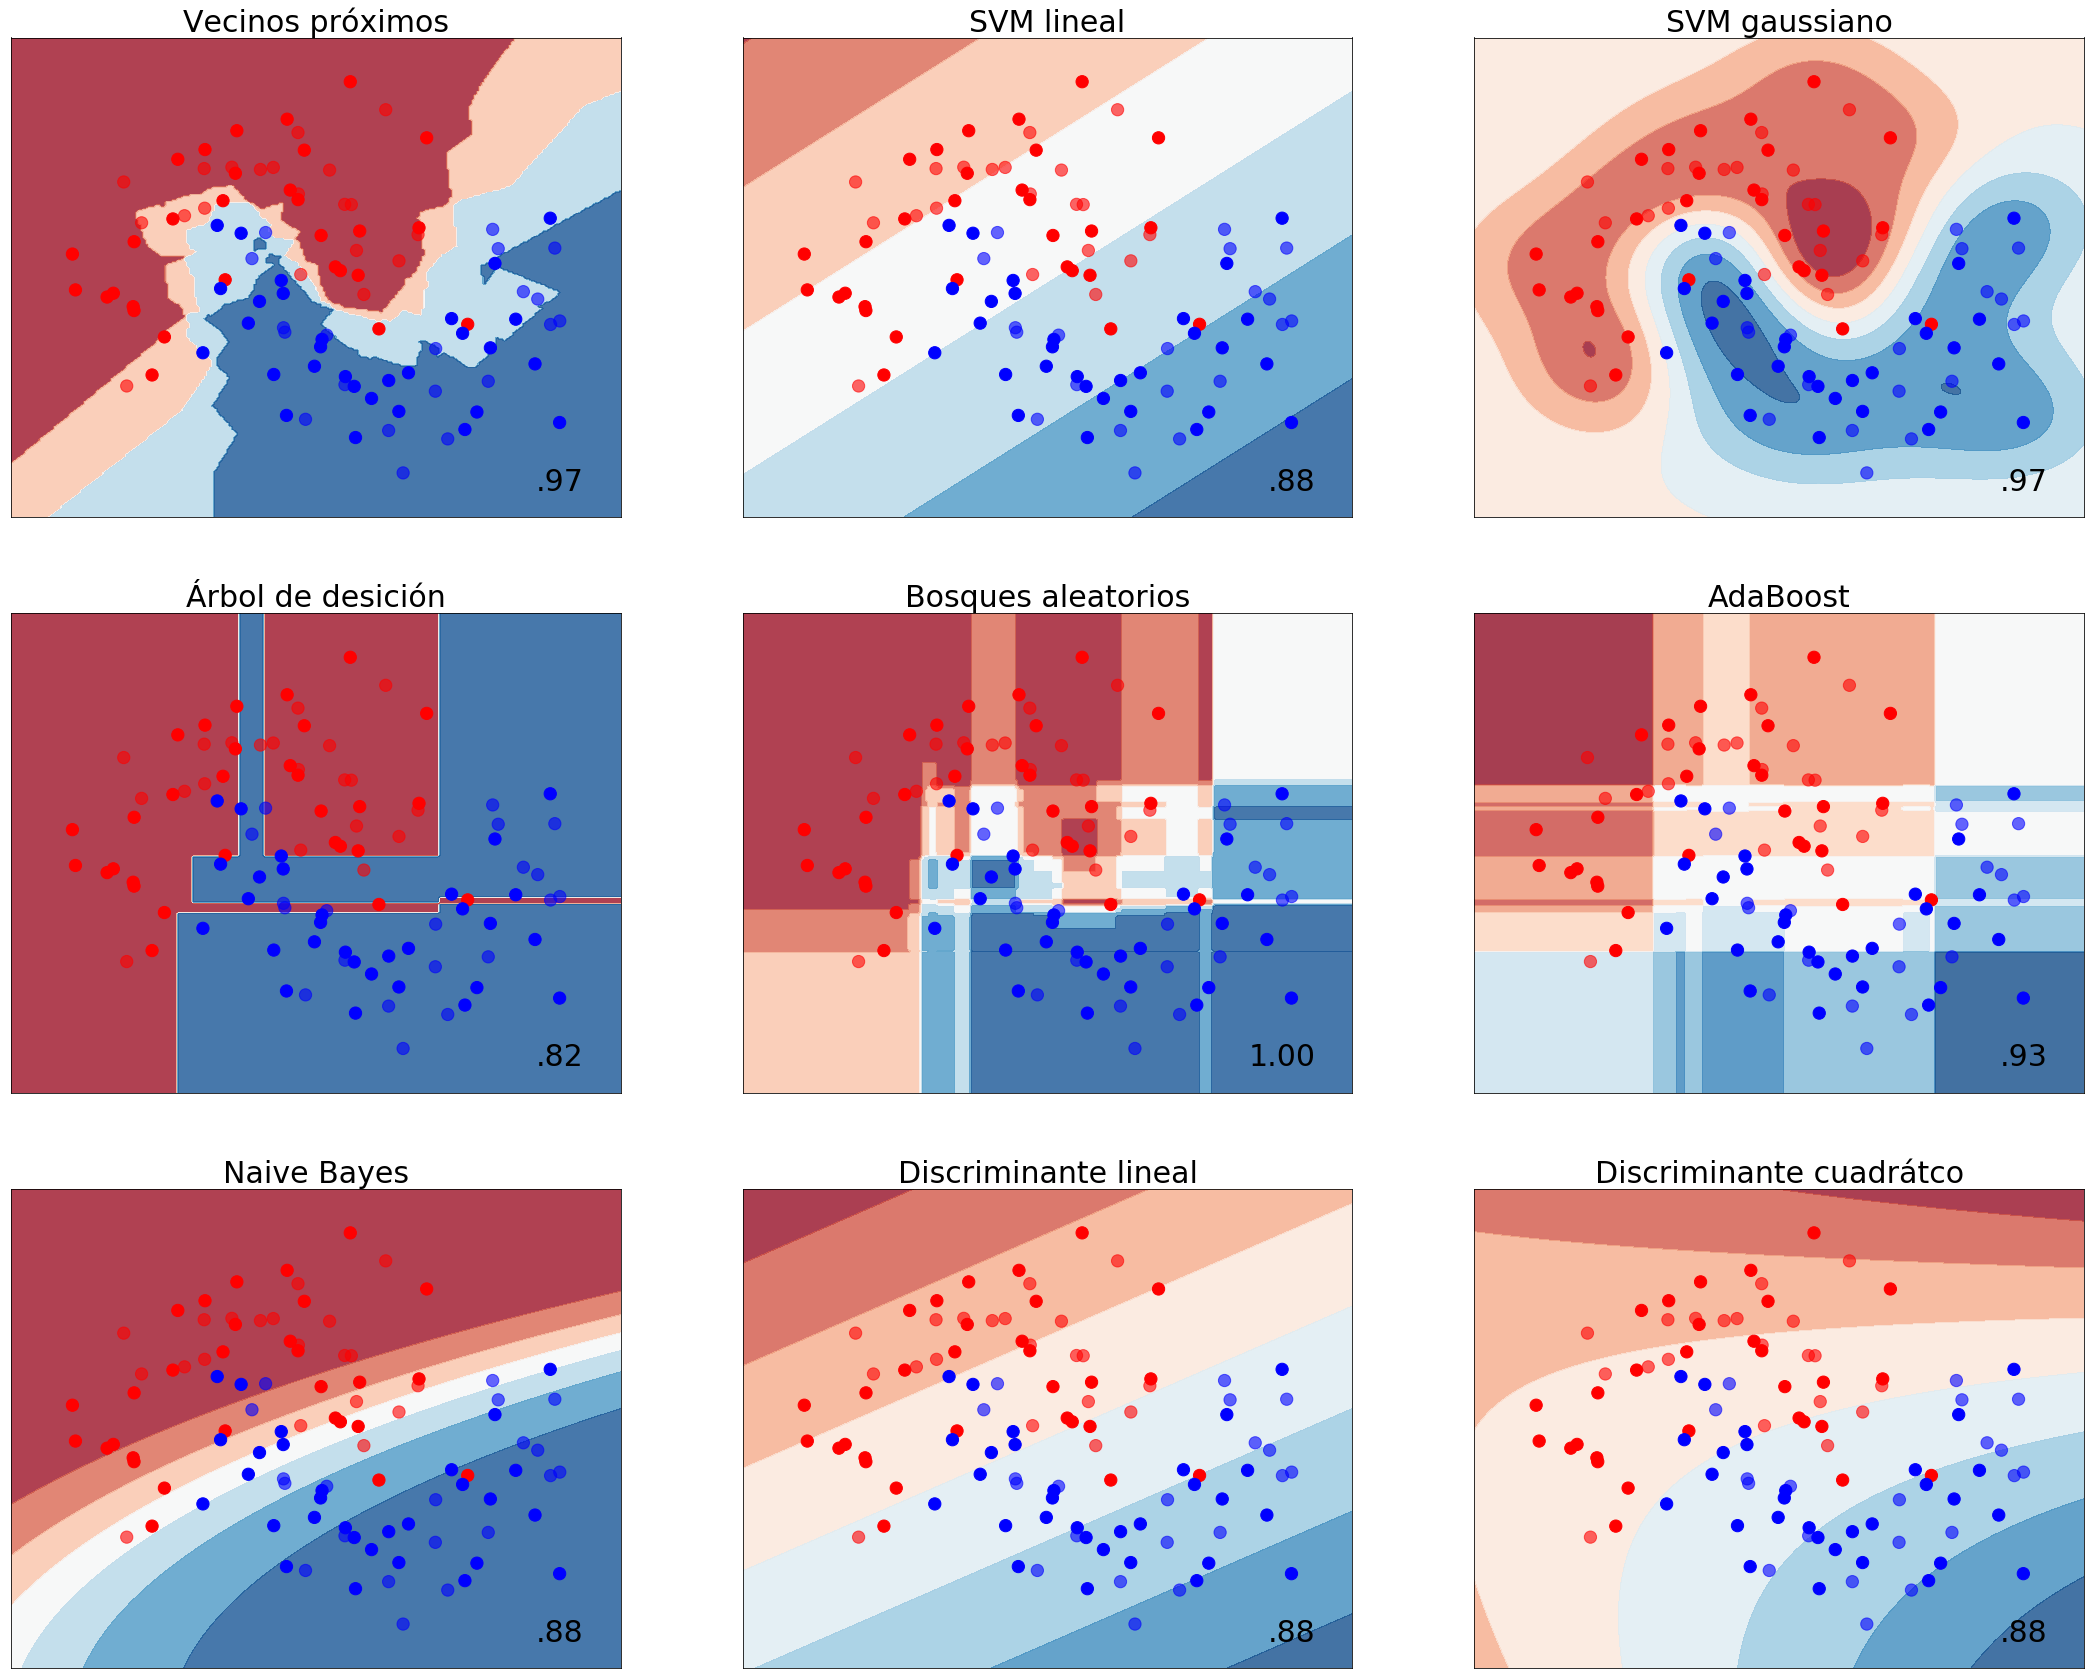

Base de datos 1


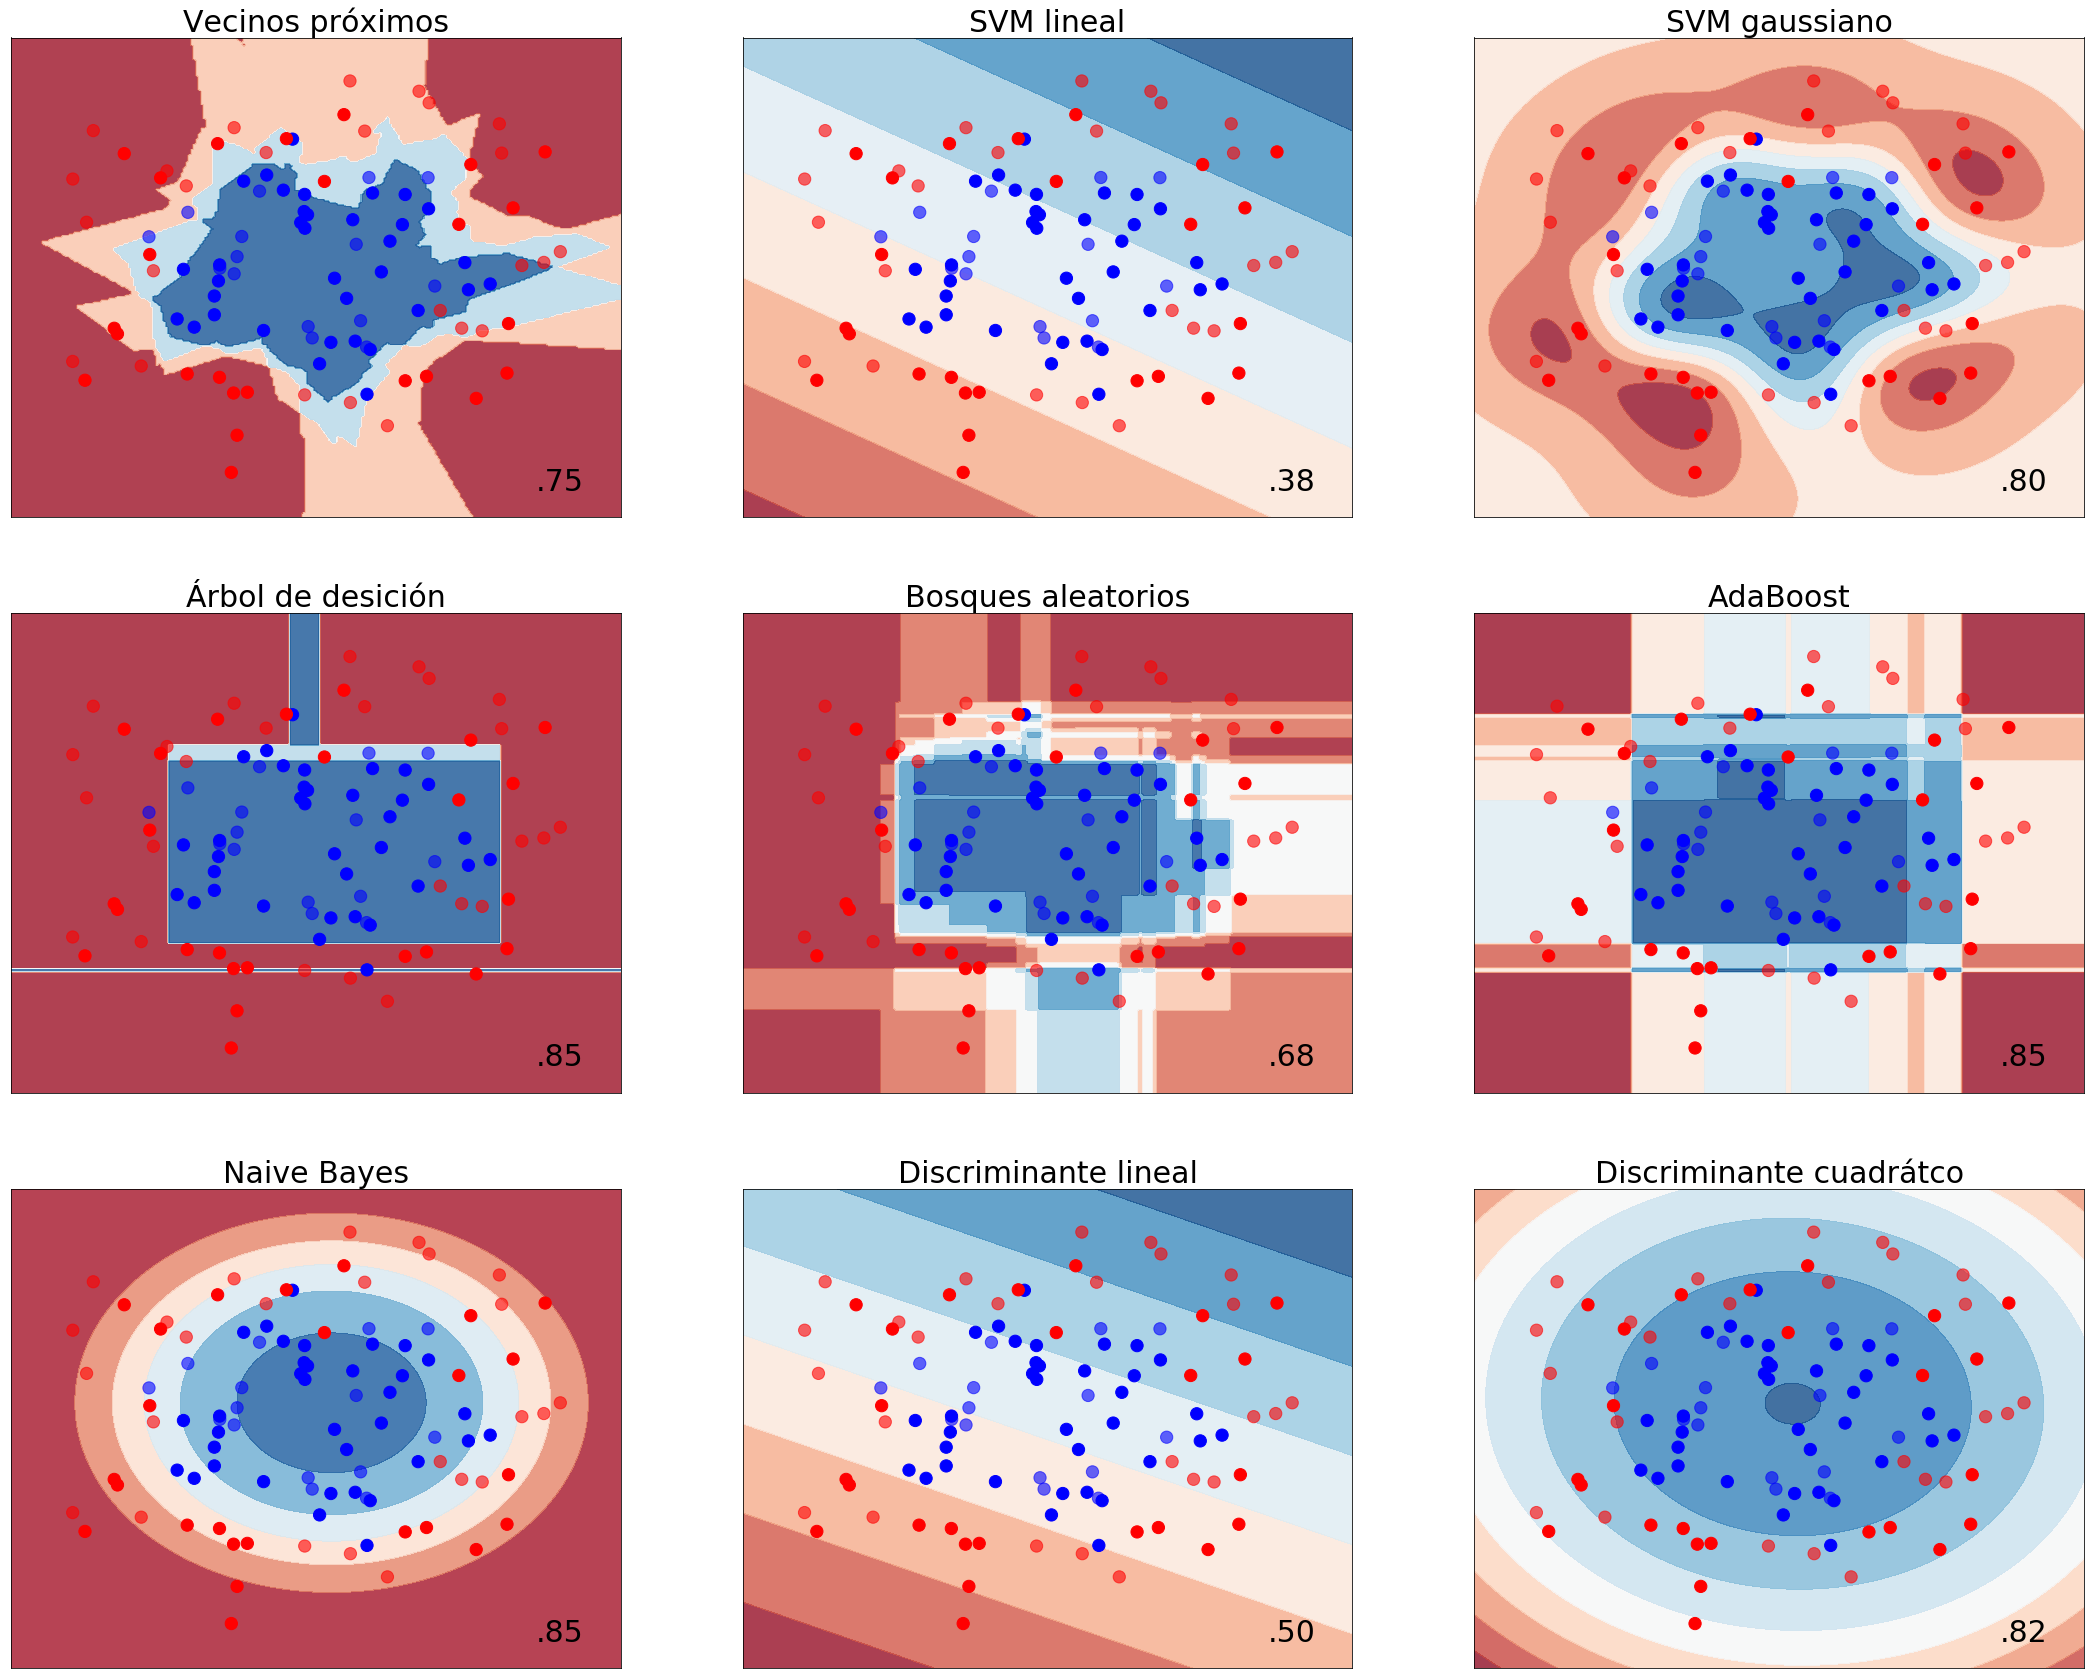

Base de datos 2


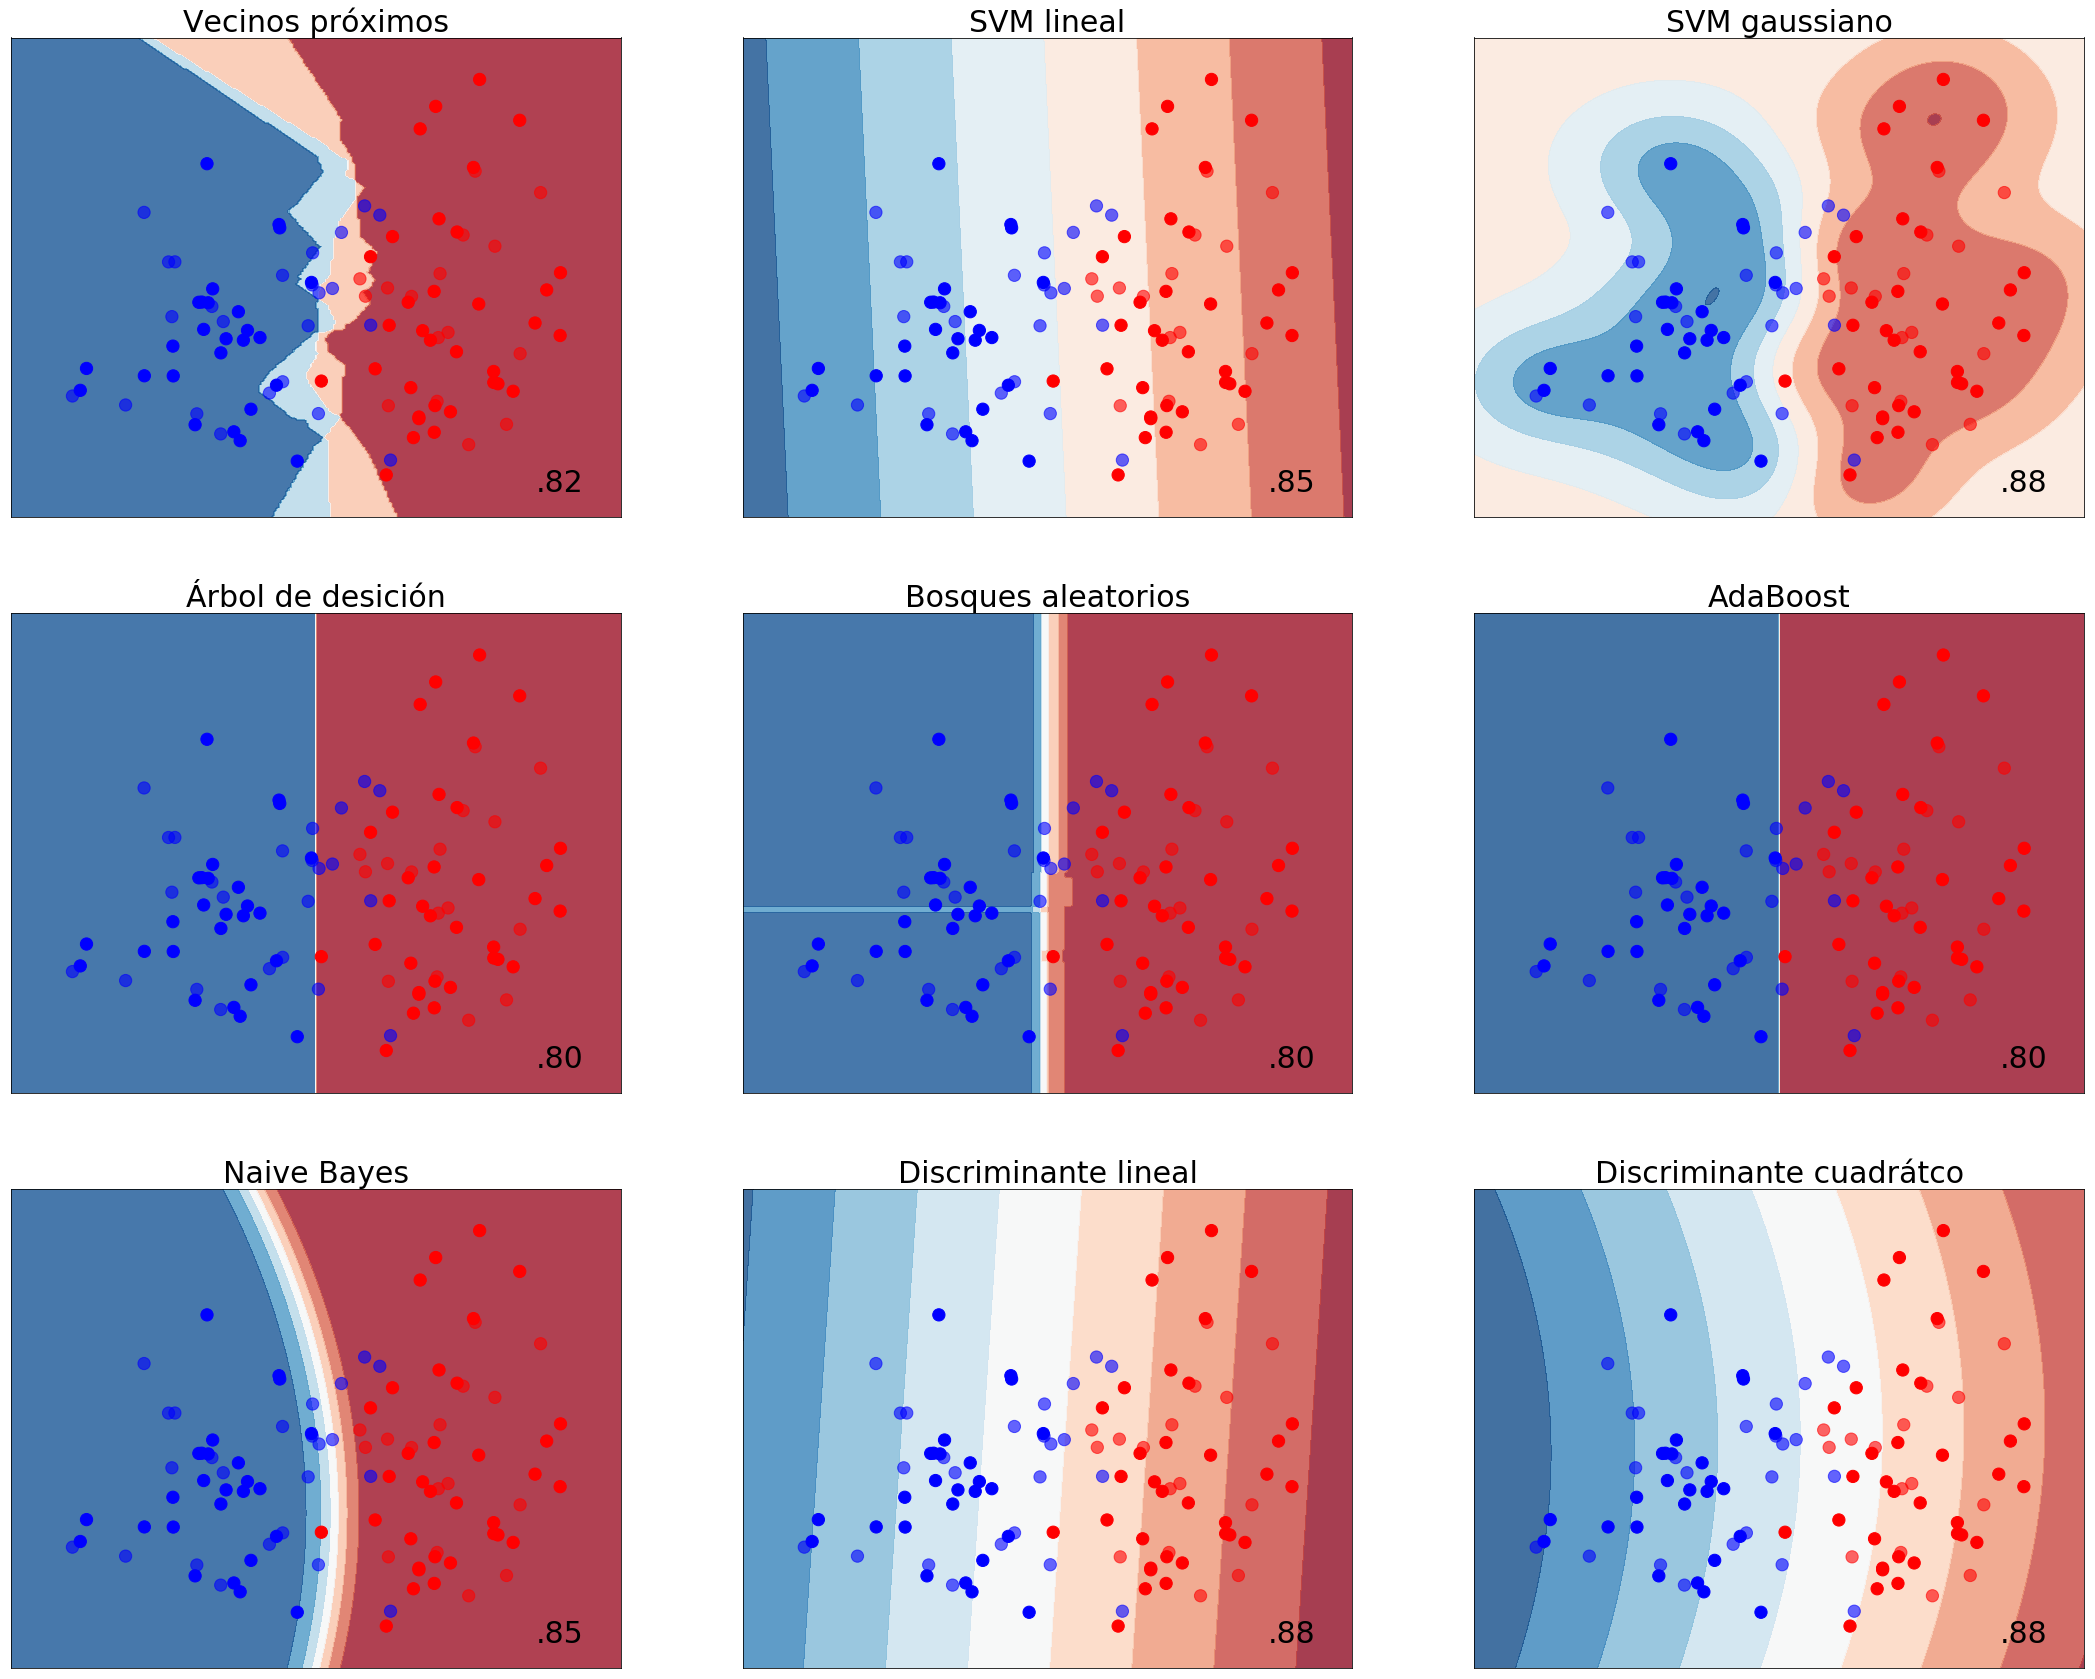

In [4]:
# Colores brillantes
cm = plt.cm.RdBu
cm_escala = ListedColormap(['#FF0000', '#0000FF'])

for (cual, ds) in enumerate(datasets):
    
    print("Base de datos {}".format(cual))
    figure = plt.figure(figsize=(30, 30))

    # Escalar y selecciona valores de entrenamiento y prueba
    X, y = ds
    X = StandardScaler().fit_transform(X)
    
    # Dividir el conjunto en un conjunto de entrenamiento y otro de aprendizaje
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    # Meshgrid para clasificar toda la región y pintar las regiones
    xx, yy = np.meshgrid(np.arange(X[:, 0].min() - .5, X[:, 0].max() + .5, 0.02),
                         np.arange(X[:, 1].min() - .5, X[:, 1].max() + .5, 0.02))

    # Por cada clasificador
    for (i, (titulo, clf)) in enumerate(zip(titulos, classifiers)):
        
        # Escoge el subplot
        ax = plt.subplot(3, 3, i + 1)
        
        # El entrenamiento!!!!
        clf.fit(X_train, y_train)
        
        # Encuentra el error de validación
        score = clf.score(X_test, y_test)

        # Clasifica cada punto en el meshgrid
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)

        # Asigna un color a cada punto
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Grafica los datos de entrenamiento y prueba
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_escala, s=150)
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_escala, s=150, alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(titulo, size=30)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=30, horizontalalignment='right')

    figure.subplots_adjust(left=.02, right=.98)
    plt.show()


## 4. Generando un conjunto de datos en forma de espiral

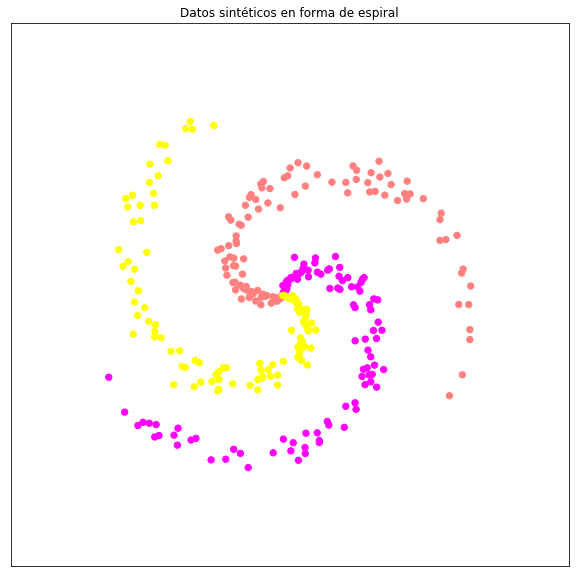

In [5]:
#  Inicialización de datos
np.random.seed(0) # Aseguramos que siempre pasa lo mismo
N = 100 # Ejemplos por clase
D = 2 # Atributos
K = 3 # Clases
X = np.zeros((N * K, D))
Y = np.zeros((N * K, 1), dtype='uint8')

# Genera datos en espiral
for clase in range(K):
  ix = list(range(N*clase, N*(clase+1)))  # Indices para cada clase
  r = np.linspace(0.0, 1, N) 
  t = np.linspace(clase * 4, (clase + 1) * 4, N) + np.random.randn(N) * 0.2 
  X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
  Y[ix] = clase

#  Grafica datos
figure = plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=Y.ravel(), s=40, cmap=plt.cm.spring)
plt.title("Datos sintéticos en forma de espiral")
plt.xlim(X[:, 0].min() - .5, X[:, 0].max() + .5)
plt.ylim(X[:, 1].min() - .5, X[:, 1].max() + .5)
plt.xticks(())
plt.yticks(())
plt.show()

### Ejercicio:

Prueba los diferentes clasificadores para este conjunto de datos. Recuerda que en este caso tenemos un problema de múltiples clases y los métodos podrían necesitar un ajuste especial. Clasifica un grid con los puntos que permita estudiar la forma de la partición del espacio, tal como se hizo en el ejemplo.

Revisa la literatura de cada método en caso que no funcionen directamente. Agrega a continuación el código que genera las gráficas.

In [6]:
classif = [
    KNeighborsClassifier(3),
    SVC(kernel="poly", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


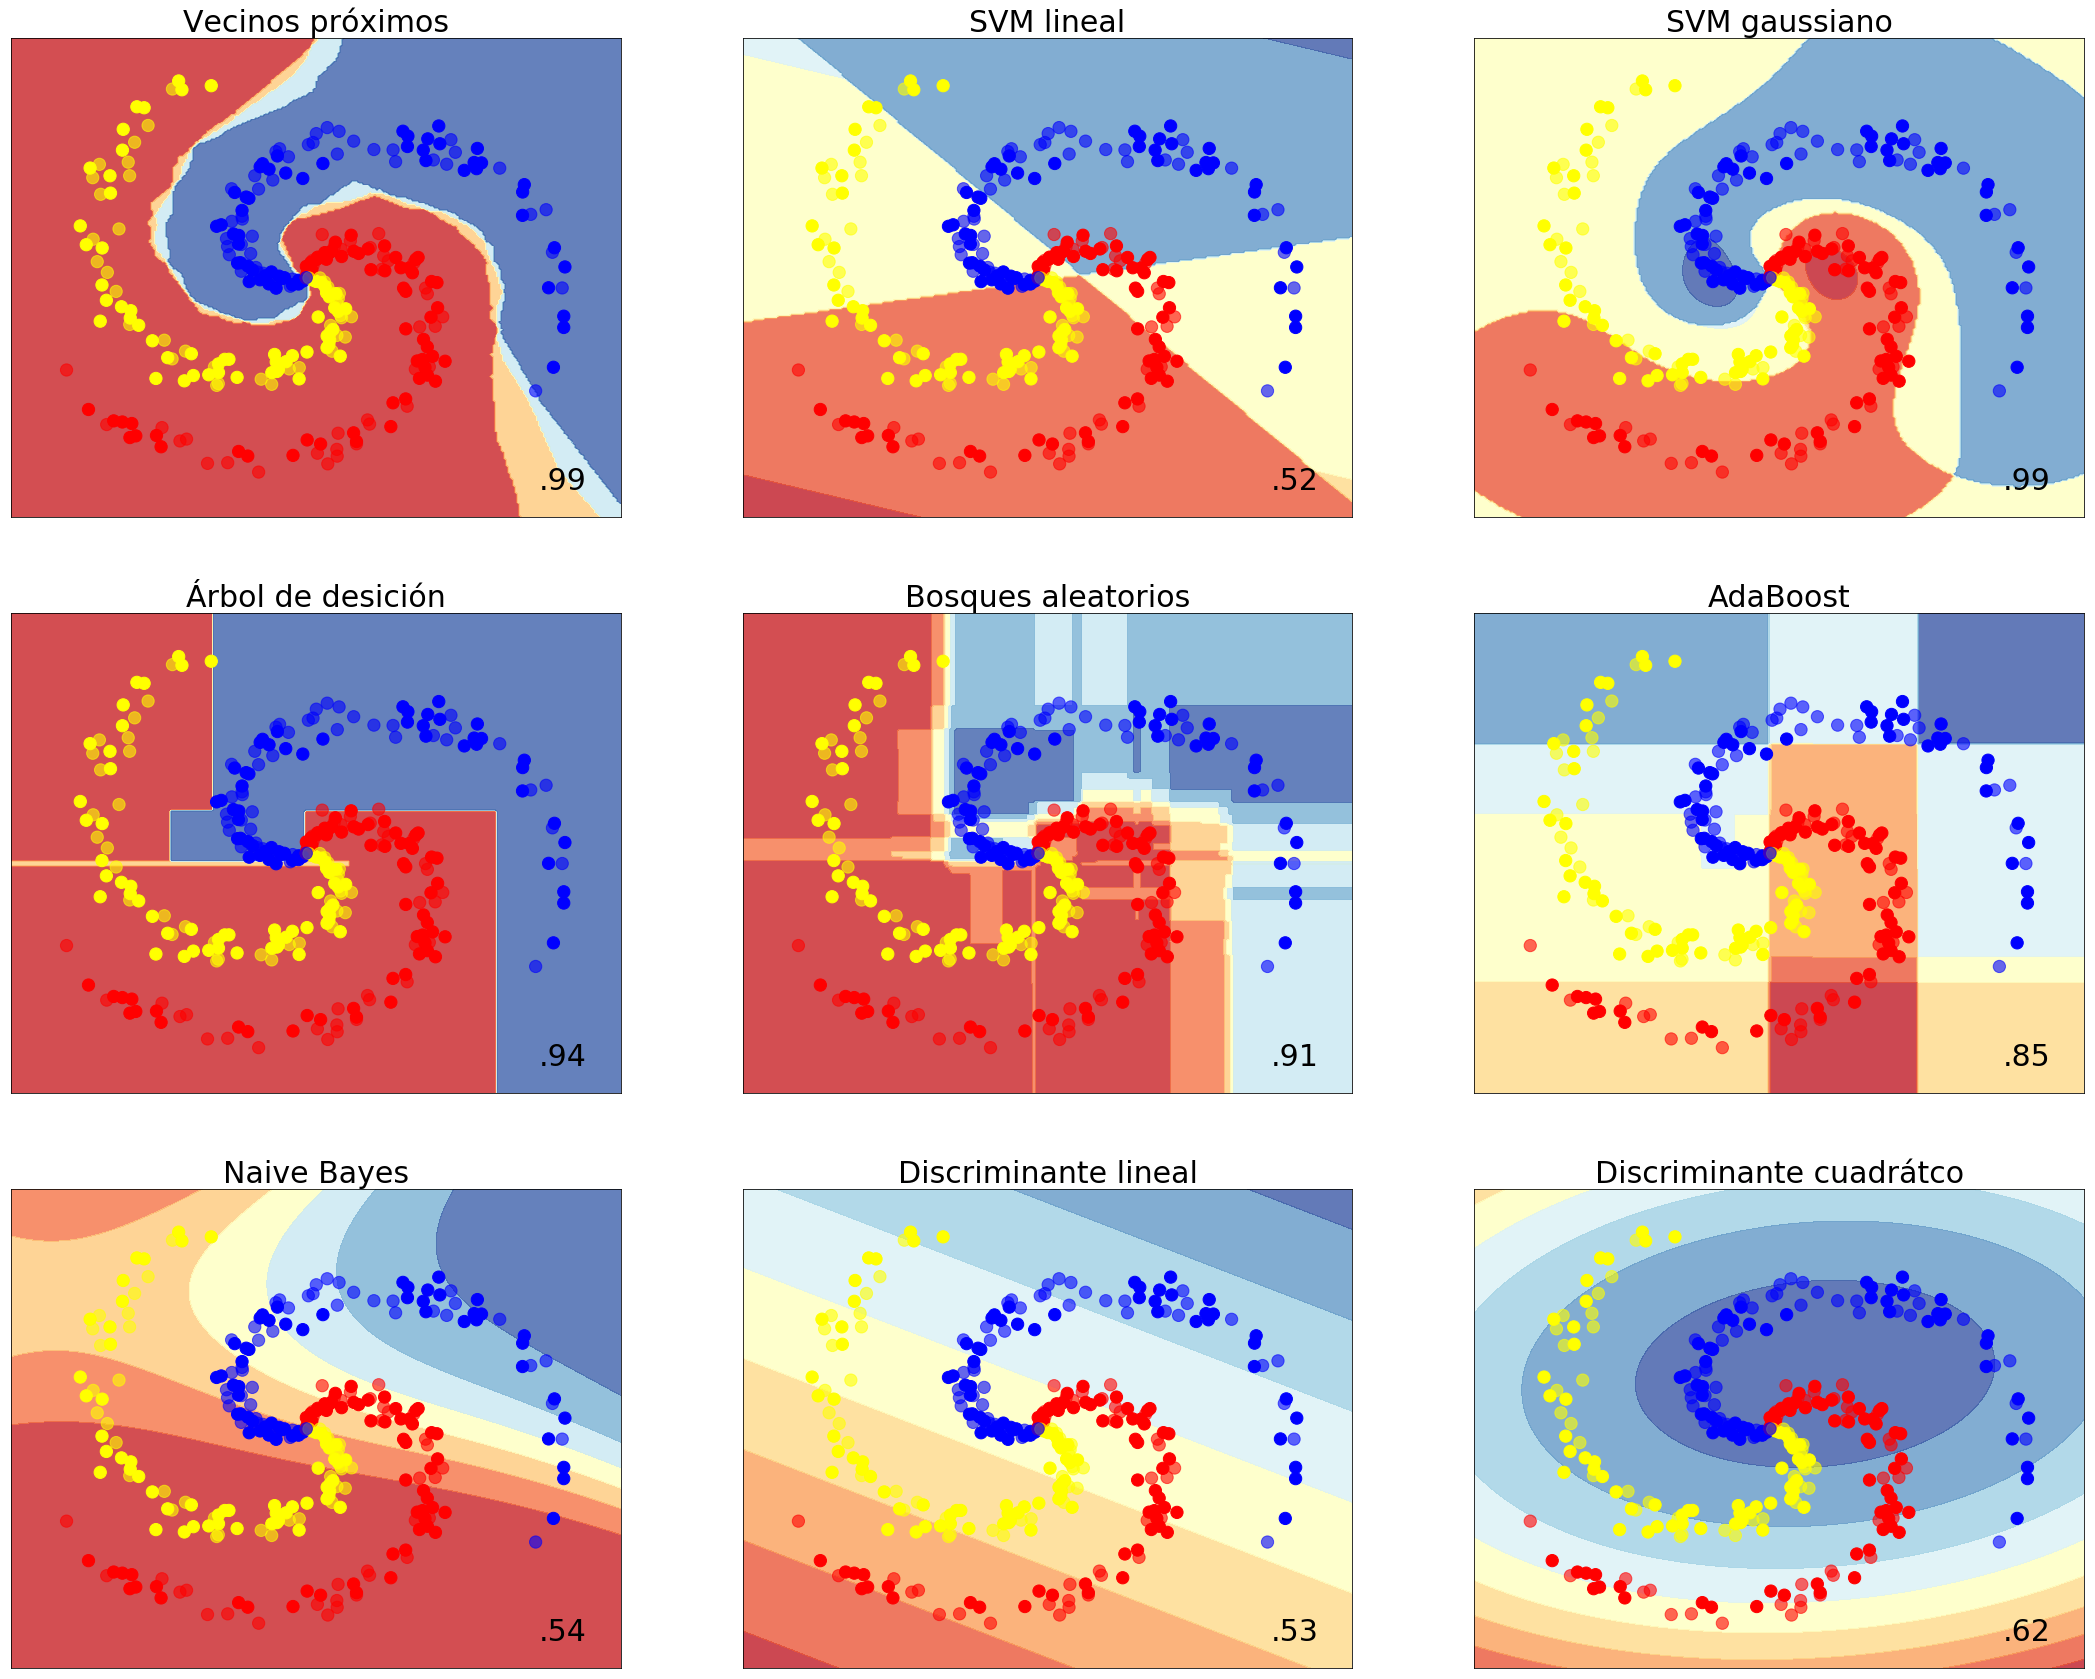

In [10]:
# Colores brillantes
cm = plt.cm.RdYlBu
cm_escala = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

figure = plt.figure(figsize=(30, 30))

# Escalar y selecciona valores de entrenamiento y prueba
#X, y = (X,Y)
X = StandardScaler().fit_transform(X)
Y = Y.reshape((Y.shape[0],))
# Dividir el conjunto en un conjunto de entrenamiento y otro de aprendizaje
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4)

# Meshgrid para clasificar toda la región y pintar las regiones
xx, yy = np.meshgrid(np.arange(X[:, 0].min() - .5, X[:, 0].max() + .5, 0.02),
                     np.arange(X[:, 1].min() - .5, X[:, 1].max() + .5, 0.02))

# Por cada clasificador
for (i, (titulo, clf)) in enumerate(zip(titulos, classifiers)):

    # Escoge el subplot
    ax = plt.subplot(3, 3, i + 1)

    # El entrenamiento!!!!
    clf.fit(X_train, y_train)

    # Encuentra el error de validación
    score = clf.score(X_test, y_test)

    # Clasifica cada punto en el meshgrid
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Asigna un color a cada punto
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Grafica los datos de entrenamiento y prueba
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_escala, s=150)
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_escala, s=150, alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(titulo, size=30)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=30, horizontalalignment='right')

figure.subplots_adjust(left=.02, right=.98)
plt.show()

## Conclusiones

### Ejercicio:

Escribe a continuación tus conlusiones, agregando lo siguiente:

1. Para cada clasificador, ¿cómo es la partición del espacio que genera?
  - Vecinos próximos: sigue las espirales que crean los datos.
  - SVM lineal: genera 4 triángulos que se intersectan en el centro del espacio.
  - SVM gaussiano: sigue las espirales que crean los datos.
  - Árbol de decisión: separa el espacio en dos áreas, tratando de mantener el espiral.
  - Bosques aleatorios: hace muchas particiones pequeñas alrededor del centro, también tratando de mantener la forma en espiral
  - AdaBoost: parecido a los bosques aleatorios pero más sencillo.
  - Naïve Bayes: crea curvas que separan el espacio cerca de las 'fronteras' de las clases.
  - Discriminante lineal: hace un barrido del espacio con líneas rectas.
  - Discriminante cuadrático: parecido a Naïve Bayes pero con más separaciones.

2. ¿Para qué casos crees que son mejores unos clasificadores a otros?

  Cuando las nubes de datos forman curvas en el espacio parecen ser mejor vecinos próximos, SVM gaussiano, árboles de decisión y bosques aleatorios. Si los datos son linealmente separables o son cúmulos bien distinguidos, el SVM lineal y el discriminante lineal paracen dar mejores resultados que los árboles de decisión y los bosques aleatorios.
  
3. ¿Existen clasificadores que se comporten más o menos parecido? ¿Los podrías reagrupar?

  Si hay clasificadores que se parecen. Los reagruparía como sigue:
  - Vecinos próximos, SVM gaussiano 
  - Árbol de decisión, bosques aleatorios, AdaBoost
  - SVM lineal, discriminante lineal
  - Naïve Bayes, discriminante cuadrático
  
4. ¿Hay algún clasificador que, vista la evidencia, ni siquiera probarías al principio? ¿Cúal(es)? ¿Porqué?
  
  Si, tanto el SVM lineal como el discriminante lineal no los probaría al principio. En todas las pruebas de esta libreta solo tuvieron un resultado decente cada uno, con lo que muestren que no son robustos a distintas distribuciones de datos.
